# Analysis

In [243]:
import matplotlib.pyplot as plt

## IO

### OpenPMD

In [244]:
import openpmd_api as io

# example: data handling
import numpy as np

In [245]:
openpmd_backend = "h5"
series = io.Series(f"diags/diag1/openpmd_%06T.{openpmd_backend}", io.Access.read_only)


In [246]:
print("openPMD version: ", series.openPMD)

openPMD version:  1.1.0


In [247]:
list(series.iterations)
i = series.iterations[64]

In [248]:
# record
B = i.meshes["B"]
B.

SyntaxError: invalid syntax (401656362.py, line 3)

In [249]:
# record
B = i.meshes["B"]

# record components
B_x = B["x"]
B_y = B["y"]
B_z = B["z"]

B_x_data = B_x.load_chunk()
B_y_data = B_y.load_chunk()
B_z_data = B_z.load_chunk()
series.flush()

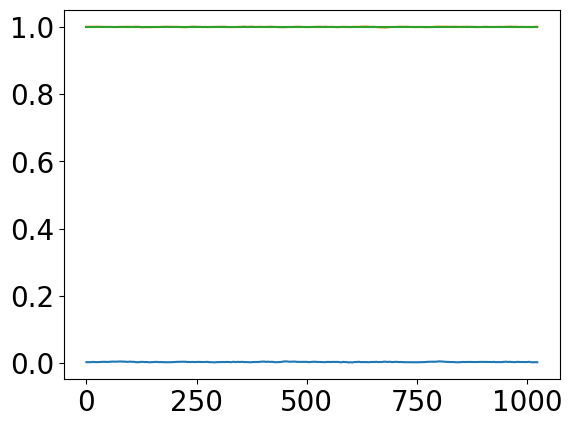

In [250]:
plt.plot(B_x_data)
plt.plot(B_y_data)
plt.plot(B_z_data)

In [156]:
import yt


In [157]:
ts = yt.load('./diags/diag???????')
ts.piter()

<generator object DatasetSeries.piter at 0x2a39e0630>

In [158]:
ds = yt.load('./diags/diag1000000')
ds.fields

yt : [INFO     ] 2024-03-08 19:49:40,356 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-03-08 19:49:40,356 Parameters: domain_dimensions         = [1024    1    1]
yt : [INFO     ] 2024-03-08 19:49:40,357 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-03-08 19:49:40,357 Parameters: domain_right_edge         = [0.00109633 1.         1.        ]


In [159]:
ad = ds.all_data()

x = ad["x"]
y = ad["y"]
z = ad["z"]

In [160]:
x

unyt_array([5.35315740e-07, 1.60594722e-06, 2.67657870e-06, ...,
            1.09365006e-03, 1.09472069e-03, 1.09579132e-03], 'm')

In [161]:
ad["Bx"]

unyt_array([0.00306796, 0.00306796, 0.00306796, ..., 0.00306796,
            0.00306796, 0.00306796], 'T')

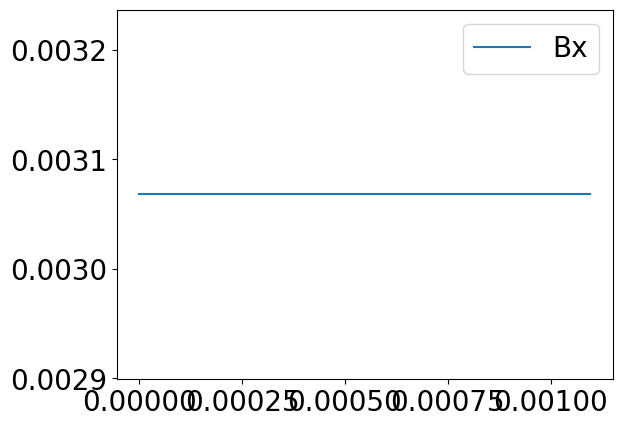

In [169]:
for field in ["Bx"]:
    plt.plot(x, ad[field], label=field)
    
plt.legend()

In [81]:
import dill
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from pywarpx import picmi

constants = picmi.constants

matplotlib.rcParams.update({"font.size": 20})

# load simulation parameters
with open("sim_parameters.dpkl", "rb") as f:
    sim = dill.load(f)

In [82]:
if sim.B_dir == 'z':
    field_idx_dict = {'z': 4, 'Ez': 7, 'Bx': 8, 'By': 9}
    data = np.loadtxt("diags/par_field_data.txt", skiprows=1)
else:
    if sim.dim == 1:
        field_idx_dict = {'z': 4, 'Ez': 7, 'Bx': 8, 'By': 9}
    else:
        field_idx_dict = {'z': 2, 'Ez': 3, 'Bx': 4, 'By': 5}
    data = np.loadtxt("diags/perp_field_data.txt", skiprows=1)

In [83]:
# step, t, z, Ez, Bx, By = raw_data.T
step = data[:,0]

num_steps = len(np.unique(step))

# get the spatial resolution
resolution = len(np.where(step == 0)[0]) - 1

# reshape to separate spatial and time coordinates
sim_data = data.reshape((num_steps, resolution+1, data.shape[1]))

In [96]:
z_grid[:10]

array([0.00000000e+00, 1.71636264e-06, 3.43272528e-06, 5.14908792e-06,
       6.86545056e-06, 8.58181320e-06, 1.02981758e-05, 1.20145385e-05,
       1.37309011e-05, 1.54472638e-05])

In [84]:
z_grid = sim_data[1, :, field_idx_dict['z']]
idx = np.argsort(z_grid)[1:]
dz = np.mean(np.diff(z_grid[idx]))
dt = np.mean(np.diff(sim_data[:,0,1]))

data = np.zeros((num_steps, resolution, 3))
for i in range(num_steps):
    data[i,:,0] = sim_data[i,idx,field_idx_dict['Bx']]
    data[i,:,1] = sim_data[i,idx,field_idx_dict['By']]
    data[i,:,2] = sim_data[i,idx,field_idx_dict['Ez']]

print(f"Data file contains {num_steps} time snapshots.")
print(f"Spatial resolution is {resolution}")

Data file contains 1757 time snapshots.
Spatial resolution is 1022


In [5]:
def get_analytic_R_mode(w):
    return w / np.sqrt(1.0 + abs(w))

def get_analytic_L_mode(w):
    return w / np.sqrt(1.0 - abs(w))

/var/folders/tg/rfd0nr_970s3mv1fspgvkkxm0000gn/T/ipykernel_56467/195135233.py:5: RuntimeWarning: invalid value encountered in sqrt
  return w / np.sqrt(1.0 - abs(w))


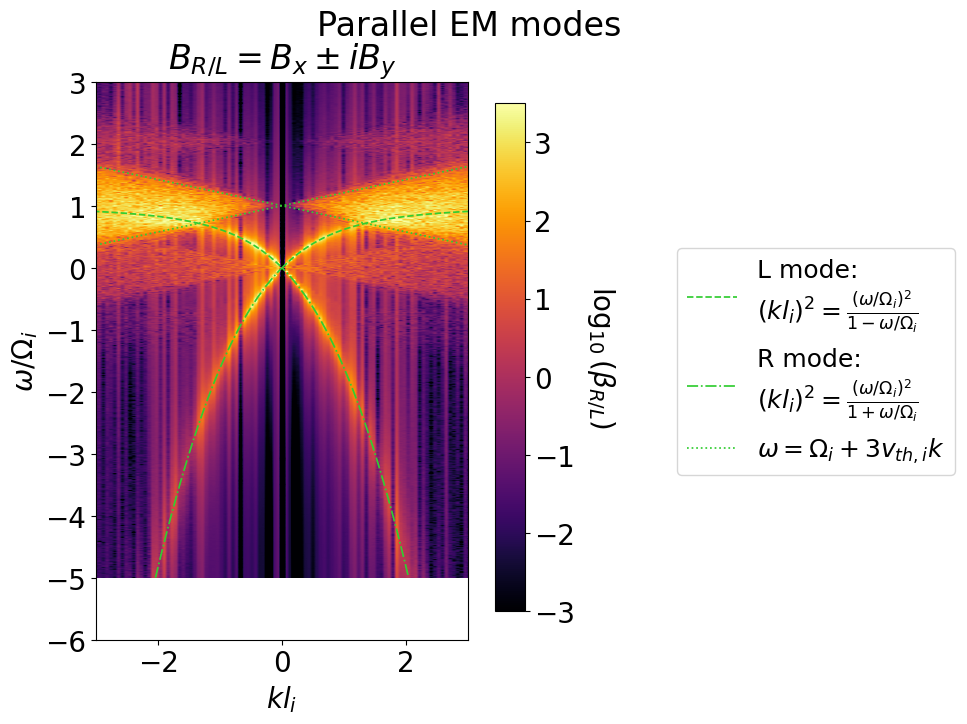

In [7]:
if sim.B_dir == 'z':
    global_norm = (
        1.0 / (2.0*constants.mu0)
        / ((3.0/2)*sim.n0*sim.T_plasma*constants.q_e)
    )
else:
    global_norm = (
        constants.ep0 / 2.0
        / ((3.0/2)*sim.n0*sim.T_plasma*constants.q_e)
    )

if sim.B_dir == 'z':
    Bl = (data[:, :, 0] + 1.0j * data[:, :, 1]) / np.sqrt(2.0)
    field_kw = np.fft.fftshift(np.fft.fft2(Bl))
else:
    field_kw = np.fft.fftshift(np.fft.fft2(data[:, :, 2]))

w_norm = sim.w_ci
if sim.B_dir == 'z':
    k_norm = 1.0 / sim.l_i
else:
    k_norm = 1.0 / sim.rho_i

k = 2*np.pi * np.fft.fftshift(np.fft.fftfreq(resolution, dz)) / k_norm
w = 2*np.pi * np.fft.fftshift(np.fft.fftfreq(num_steps, dt)) / w_norm
w = -np.flipud(w)

# aspect = (xmax-xmin)/(ymax-ymin) / aspect_true
extent = [k[0], k[-1], w[0], w[-1]]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 7.25))

if sim.B_dir == 'z' and sim.dim == 1:
    vmin = -3
    vmax = 3.5
else:
    vmin = None
    vmax = None

im = ax1.imshow(
    np.log10(np.abs(field_kw**2) * global_norm), extent=extent,
    aspect="equal", cmap='inferno', vmin=vmin, vmax=vmax
)

# Colorbars
fig.subplots_adjust(right=0.5)
cbar_ax = fig.add_axes([0.525, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax, orientation='vertical')

#cbar_lab = r'$\log_{10}(\frac{|B_{R/L}|^2}{2\mu_0}\frac{2}{3n_0k_BT_e})$'
if sim.B_dir == 'z':
    cbar_lab = r'$\log_{10}(\beta_{R/L})$'
else:
    cbar_lab = r'$\log_{10}(\varepsilon_0|E_z|^2/(3n_0k_BT_e))$'
cbar_ax.set_ylabel(cbar_lab, rotation=270, labelpad=30)

if sim.B_dir == 'z':
    # plot the L mode
    ax1.plot(get_analytic_L_mode(w), np.abs(w), c='limegreen', ls='--', lw=1.25,
            label='L mode:\n'+r'$(kl_i)^2=\frac{(\omega/\Omega_i)^2}{1-\omega/\Omega_i}$')
    # plot the R mode
    ax1.plot(get_analytic_R_mode(w), -np.abs(w), c='limegreen', ls='-.', lw=1.25,
        label='R mode:\n'+r'$(kl_i)^2=\frac{(\omega/\Omega_i)^2}{1+\omega/\Omega_i}$')

    ax1.plot(k,1.0+3.0*sim.v_ti/w_norm*k*k_norm, c='limegreen', ls=':', lw=1.25, label = r'$\omega = \Omega_i + 3v_{th,i} k$')
    ax1.plot(k,1.0-3.0*sim.v_ti/w_norm*k*k_norm, c='limegreen', ls=':', lw=1.25)

else:
    # digitized values from Munoz et al. (2018)
    x = [0.006781609195402272, 0.1321379310344828, 0.2671034482758621, 0.3743678160919539, 0.49689655172413794, 0.6143908045977011, 0.766022988505747, 0.885448275862069, 1.0321149425287355, 1.193862068965517, 1.4417701149425288, 1.7736781609195402]
    y = [-0.033194664836814436, 0.5306857657503109, 1.100227301968521, 1.5713856842646996, 2.135780760818287, 2.675601492473303, 3.3477291246729854, 3.8469357121413563, 4.4317021915340735, 5.1079898786293265, 6.10275764463696, 7.310074194793499]
    ax1.plot(x, y, c='limegreen', ls='-.', lw=1.5, label="X mode")

    x = [3.9732873563218387, 3.6515862068965514, 3.306275862068966, 2.895655172413793, 2.4318850574712645, 2.0747586206896553, 1.8520229885057473, 1.6589195402298849, 1.4594942528735633, 1.2911724137931033, 1.1551264367816092, 1.0335402298850576, 0.8961149425287356, 0.7419770114942528, 0.6141379310344828, 0.4913103448275862]
    y = [1.1145945018655916, 1.1193978642192393, 1.1391259596002916, 1.162971222713042, 1.1986533430544237, 1.230389844319595, 1.2649997855641806, 1.3265857528841618, 1.3706737573444268, 1.4368486511986962, 1.4933310460179268, 1.5485268259210019, 1.6386327572157655, 1.7062658146416778, 1.7828194021529358, 1.8533687867221342]
    ax1.plot(x, y, c='limegreen', ls=':', lw=2, label="Bernstein modes")

    x = [3.9669885057471266, 3.6533333333333333, 3.3213563218390805, 2.9646896551724136, 2.6106436781609195, 2.2797011494252875, 1.910919540229885, 1.6811724137931034, 1.4499540229885057, 1.2577011494252872, 1.081057471264368, 0.8791494252873564, 0.7153103448275862]
    y = [2.2274306300124374, 2.2428271218424327, 2.272505039241755, 2.3084873697302397, 2.3586224642964364, 2.402667581592829, 2.513873997512545, 2.5859673199811297, 2.6586610627439207, 2.7352146502551786, 2.8161427284813656, 2.887850066475104, 2.9455761890466183]
    ax1.plot(x, y, c='limegreen', ls=':', lw=2)

    x = [3.9764137931034487, 3.702022988505747, 3.459793103448276, 3.166712643678161, 2.8715862068965516, 2.5285057471264367, 2.2068505747126435, 1.9037011494252871, 1.6009885057471265, 1.3447816091954023, 1.1538850574712645, 0.9490114942528736]
    y = [3.3231976669382854, 3.34875841660591, 3.378865205643951, 3.424454260839731, 3.474160483767209, 3.522194107303684, 3.6205343740618434, 3.7040356821203417, 3.785435519149119, 3.868851052879873, 3.9169704507440923, 3.952481022429987]
    ax1.plot(x, y, c='limegreen', ls=':', lw=2)

    x = [3.953609195402299, 3.7670114942528734, 3.5917471264367817, 3.39735632183908, 3.1724137931034484, 2.9408045977011494, 2.685977011494253, 2.4593563218390804, 2.2203218390804595, 2.0158850574712646, 1.834183908045977, 1.6522758620689655, 1.4937471264367814, 1.3427586206896551, 1.2075402298850575]
    y = [4.427971008277223, 4.458335120298495, 4.481579963117039, 4.495861388686366, 4.544581206844791, 4.587425483552773, 4.638160998413175, 4.698631899472488, 4.757987734271133, 4.813955483123902, 4.862332203971352, 4.892481880173264, 4.9247759145687695, 4.947934983059571, 4.953124329888064]
    ax1.plot(x, y, c='limegreen', ls=':', lw=2)

# ax1.legend(loc='upper left')
fig.legend(loc=7, fontsize=18)

if sim.B_dir == 'z':
    ax1.set_xlabel(r'$k l_i$')
    ax1.set_title('$B_{R/L} = B_x \pm iB_y$')
    fig.suptitle("Parallel EM modes")
    ax1.set_xlim(-3, 3)
    ax1.set_ylim(-6, 3)
    dir_str = 'par'
else:
    ax1.set_xlabel(r'$k \rho_i$')
    ax1.set_title('$E_z(k, \omega)$')
    fig.suptitle(f"Perpendicular EM modes (ion Bernstein) - {sim.dim}D")
    ax1.set_xlim(-3, 3)
    ax1.set_ylim(0, 8)
    dir_str = 'perp'

ax1.set_ylabel(r'$\omega / \Omega_i$')

plt.savefig(
    f"spectrum_{dir_str}_{sim.dim}d_{sim.substeps}_substeps_{sim.eta}_eta.png",
    bbox_inches='tight'
)
if not sim.test:
    plt.show()

In [92]:
idx

array([1022,    1,    2, ..., 1019, 1020, 1021])

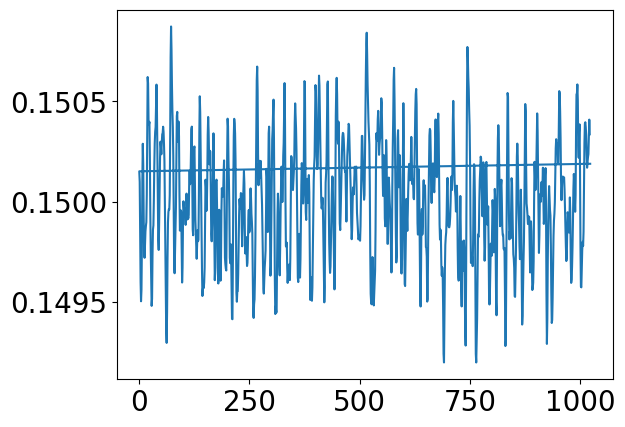

In [101]:
plt.plot(idx, data[1200,:,1])

In [ ]:
if sim.test:
    import os
    import sys
    import checksumAPI
    
    sys.path.insert(1, '../../../../warpx/Regression/Checksum/')

    # this will be the name of the plot file
    fn = sys.argv[1]
    test_name = os.path.split(os.getcwd())[1]
    checksumAPI.evaluate_checksum(test_name, fn)
